# Experiment templates
**Author: Hafsa Bousbiat**


NILMtk is toolkit offering a variety of tools for scholars to help them analyse NILM datasets. The recently introduced API made it very easy for users to interact with the toolkit and perform experiments using different experimental setups. However, the use of different setups in different papers makes it difficult to compare and analyse the results that are obtained in order to have a fair benchmarking.  Fo this reason, the deep-nilmtk takes the pipeline automation a step further and offer a pre-configured templates for the experiments. The current version contain only one template for the ukdale. However, this componenet is flexible and subject to extension for scholars to share their designs in future versions.


The current notebook demonstrates of the ukdale template to train the washing machine. One baseline is used for this

In [32]:
from deep_nilmtk.disaggregator import NILMExperiment
from deep_nilmtk.models.pytorch import UNETNILM
from deep_nilmtk.data.loader.pytorch import GeneralDataLoader
from deep_nilmtk.utils.templates import ExperimentTemplate

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
DATA_PATH = '../../data/ukdale.h5'

In [6]:
template = ExperimentTemplate( data_path=DATA_PATH,
                 template_name='ukdale',
                 list_appliances=['washing machine'],
                 list_baselines_backends=[('Seq2Pointbaseline', 'pytorch')],
                 in_sequence=121,
                 out_sequence=1,
                 max_epochs=1)

{'power': {'mains': ['active'], 'appliance': ['active']}, 'sample_rate': 8, 'appliances': ['washing machine'], 'artificial_aggregate': False, 'DROP_ALL_NANS': True, 'methods': {'Seq2Pointbaseline': <deep_nilmtk.disaggregator.nilm_experiment.NILMExperiment object at 0x0000027DA6AAC8B0>}, 'train': {'datasets': {'ukdale': {'path': '../../data/ukdale.h5', 'buildings': {1: {'start_time': '2015-01-04', 'end_time': '2015-03-30'}}}}}, 'test': {'datasets': {'ukdale': {'path': '../../data/ukdale.h5', 'buildings': {1: {'start_time': '2015-04-16', 'end_time': '2015-05-15'}}}}, 'metrics': ['mae', 'nde', 'rmse', 'f1score']}}


In [11]:
template.run_template('unet_with_baselines',
                     '../../unet_with_baselines',
                     '../../unet_with_baselines/mlflow')

Joint Testing for all algorithms
Loading data for  ukdale  dataset


Dropping missing values
Generating predictions for : Seq2Pointbaseline
processed 4827: 100%|██████████████████████████████████████████████████████████████| 4827/4827 [01:00<00:00, 79.68it/s]

............  mae  ..............
                 Seq2Pointbaseline
washing machine          18.733416
............  nde  ..............
                 Seq2Pointbaseline
washing machine            0.39773
............  rmse  ..............
                 Seq2Pointbaseline
washing machine          89.940291
............  f1score  ..............
                 Seq2Pointbaseline
washing machine           0.559005
Experiment took: 1.6 minutes


In [7]:
unet_nilm = NILMExperiment({
                "model_class": UNETNILM,
                "loader_class": GeneralDataLoader,
                "model_name": 'unet101',
                'backend':'pytorch',
                'in_size': 121,
                'out_size':1,
                'custom_preprocess':None,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':'z-norm',
                'seq_type':'seq2point',
                'point_position':'mid_position',
                'learning_rate':10e-5,
                'max_nb_epochs': 1
                })
template.extend_experiment({
    'unet':unet_nilm
})

template.__print__()
template.run_template('unet_with_baselines',
                     '../../unet_with_baselines',
                     '../../unet_with_baselines/mlflow')

Joint Testing for all algorithms
Loading data for  ukdale  dataset


Dropping missing values
Generating predictions for : Seq2Pointbaseline
processed 4827: 100%|██████████████████████████████████████████████████████████████| 4827/4827 [01:02<00:00, 77.78it/s]

Generating predictions for : unet101


processed: 4827: 100%|█████████████████████████████████████████████████████████████| 4827/4827 [00:54<00:00, 88.76it/s]


............  mae  ..............
                 Seq2Pointbaseline       unet
washing machine          18.733416  19.537519
............  nde  ..............
                 Seq2Pointbaseline      unet
washing machine            0.39773  0.402951
............  rmse  ..............
                 Seq2Pointbaseline      unet
washing machine          89.940291  91.12097
............  f1score  ..............
                 Seq2Pointbaseline      unet
washing machine           0.559005  0.372393
Experiment took: 2.9 minutes


## Check the results

In [9]:
with open('../../unet_with_baselines/unet_with_baselines.p', 'rb') as f:
    results = pickle.load(f)
results.keys()

dict_keys(['error_keys', 'errors', 'train_mains', 'train_submeters', 'test_mains', 'test_submeters', 'gt', 'predictions', 'execution_time'])

In [30]:
wm_results=pd.DataFrame({
    key: results['predictions'][key].values.reshape(-1) for key in results['predictions']
}, index= results['test_submeters'][0][1][0].index)
wm_results['True consumption']= results['test_submeters'][0][1][0].values

wm_results.head()

,Seq2Pointbaseline,unet,True consumption
2015-04-16 00:00:00+01:00,0.0,13.842941,0.0
2015-04-16 00:00:08+01:00,0.0,12.462780,0.0
2015-04-16 00:00:16+01:00,0.0,10.744602,0.0
2015-04-16 00:00:24+01:00,0.0,9.442066,0.0
2015-04-16 00:00:32+01:00,0.0,8.215725,0.0


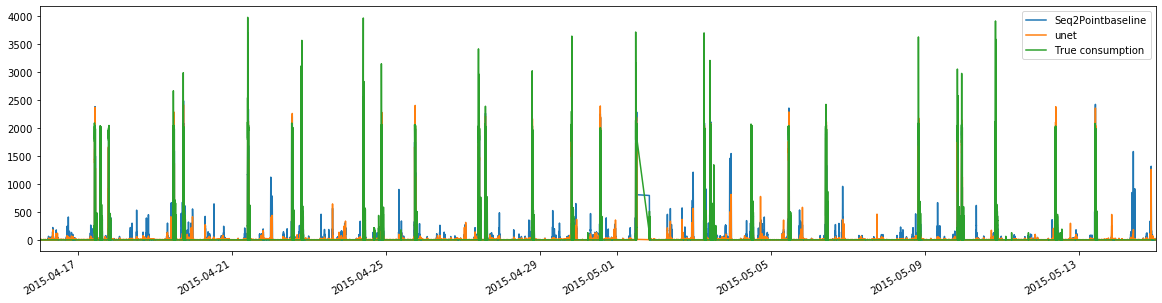

In [34]:
wm_results.plot(figsize=(20,5))

Cool!! We obtained the results of the experiment. Let's now zoom a bit and look at one activation.

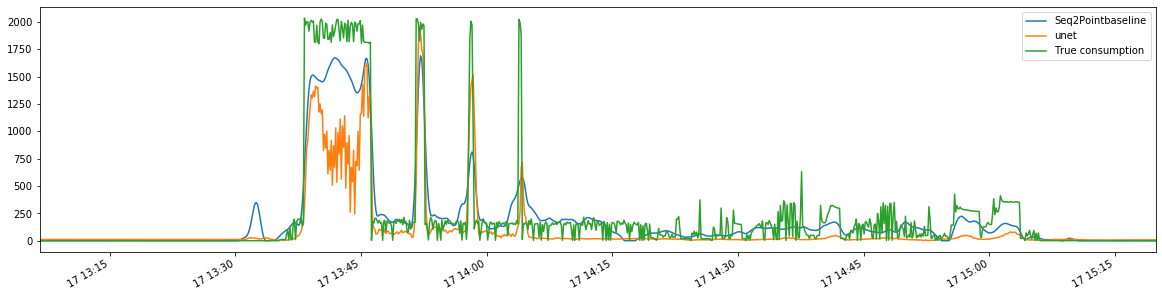

In [48]:
wm_results.iloc[16700:17700].plot(figsize=(20,5))